In [1]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox

%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
import rospy
import actionlib
from actionlib import GoalStatus
from assignment2_rt.msg import PlanningAction, PlanningGoal
from assignment2_rt.msg import Robot_info
from nav_msgs.msg import Odometry
from sensor_msgs.msg import LaserScan

In [2]:
pub_position_vel = None
client = None
out_server = widgets.Output()
out = widgets.Output()
ui, x_widget, y_widget = None, None, None

pos_x, pos_y = [], []
successes = 0
failures = 0

In [3]:
x_val = widgets.FloatText(value=0.0, description='X [m]:', disabled=True)
y_val = widgets.FloatText(value=0.0, description='Y [m]:', disabled=True)
closest_ob = widgets.FloatText(value=0.0, description='closest obstacle [m]:', disabled=True)

xy_row = HBox([x_val, y_val])

dashboard = VBox([xy_row, closest_ob])

In [4]:
def odom_callback(msg): 
    global pub_position_vel
    robot_info = Robot_info()
    robot_info.x = msg.pose.pose.position.x
    robot_info.y = msg.pose.pose.position.y
    robot_info.vel_x = msg.twist.twist.linear.x
    robot_info.vel_z = msg.twist.twist.angular.z

    pub_position_vel.publish(robot_info)
    
    x_val.value = robot_info.x
    y_val.value = robot_info.y
    
    pos_x.append(robot_info.x)
    pos_y.append(robot_info.y)
    
def scan_callback(msg):
    global closest_ob
    valid = [r for r in msg.ranges if not (math.isinf(r) or math.isnan(r))]
    if valid:
        closest = min(valid)
    else:
        closest = float('inf')
    closest_ob.value = closest

In [5]:
display(out_server)

Output()

In [6]:
def feedback_callback(feedback):
    global out, successes
    with out:
        if feedback.stat == "Target reached!":
            successes += 1
            print("Target reached")
            print("Target reached\n{}\nStatus: {}\n".format(feedback.actual_pose, feedback.stat))

def send_goal(client, x, y):
    global out
    goal = PlanningGoal()
    goal.target_pose.pose.position.x = x
    goal.target_pose.pose.position.y = y
    
    goal.target_pose.pose.position.z = 0.0      
    goal.target_pose.pose.orientation.x = 0.0  
    goal.target_pose.pose.orientation.y = 0.0  
    goal.target_pose.pose.orientation.z = 0.0   
    goal.target_pose.pose.orientation.w = 0.0   

    client.send_goal(goal, feedback_cb=feedback_callback)
    with out:
        print("Goal sent")

def cancel_goal(client):
    global out, failures
    with out:
        if client.get_state() in [GoalStatus.ACTIVE, GoalStatus.PENDING]:
            print("Cancelling current goal")
            client.cancel_goal()
            rospy.sleep(0.5)  # Timeout for forward the cancel
            state = client.get_state()
            if state in [GoalStatus.PREEMPTED, GoalStatus.RECALLED]:
                failures += 1
                print("Goal successfully cancelled")
            else:
                print("Failed to cancel the goal")
        else:
            print("No active goal to cancel.")

def main():
    global pub_position_vel, client, out_server
    rospy.init_node('action_client')
    pub_position_vel = rospy.Publisher('/robot_information', Robot_info, queue_size=10)
    with out_server:
        print("Wait for the message of topic `/odom`")
    rospy.wait_for_message('/odom', Odometry)
    rospy.Subscriber('/odom', Odometry, odom_callback)
    
    with out_server:
        print("Wait for the message of topic `/scan`")
    rospy.wait_for_message('/scan', LaserScan)
    rospy.Subscriber('/scan', LaserScan, scan_callback)

    client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
    with out_server:
        print("Wait the action server starts")
    client.wait_for_server()
    with out_server:
        print("All components started")

try:
    main()
except rospy.ROSInterruptException:
    global out_server
    with out_server:
        print("Program interrupted")

In [7]:
def confirm_clicked(b):
    global x_widget, y_widget, out
    
    if out is not None:
        out.clear_output()
            
    with out:
        x, y = x_widget.value, y_widget.value
        if x is None or y is None:
            print("Enter only valid values for X and Y")
            return
        send_goal(client, x, y)
        print(f"Goal set to (X: {x:.2f}, Y: {y:.2f})")
        
def ask_input():
    global x_widget, y_widget, ui
    
    x_widget = widgets.BoundedFloatText(value=0.0, min=-20.0, max=20.0, step=1, description='X:')
    y_widget = widgets.BoundedFloatText(value=0.0, min=-20.0, max=20.0, step=1, description='Y:')
    
    confirm_button = widgets.Button(description='Send goal')   

    ui = widgets.VBox([x_widget, y_widget, confirm_button])
    display(ui)
    
    confirm_button.on_click(confirm_clicked)

In [8]:
display(dashboard)

In [9]:
command = widgets.Dropdown(
    options=[('Select a command', 'n'),
            ('Set a new goal (s)', 's'),
             ('Cancel the current goal (c)', 'c'),
             ('Quit the action client (q)', 'q')],
    value='n',
    description='Command:',
)
display(command)

def command_change(change):
    global client
    cmd = change['new']
    if cmd == 'n':
        if ui is not None:
            ui.layout.display = 'none'
    elif cmd == 's':
        if out is not None:
            out.clear_output()
        ask_input()
    elif cmd == 'c':
        if out is not None:
            out.clear_output()
        if ui is not None:
            ui.layout.display = 'none'
        cancel_goal(client)
    elif cmd == 'q':
        command.disabled = True
        with out:
            print("Quit from widget")
        rospy.signal_shutdown("Quit from widget")
        
command.observe(command_change, names='value')

Dropdown(description='Command:', options=(('Select a command', 'n'), ('Set a new goal (s)', 's'), ('Cancel the…

In [10]:
display(out)

Output()

<IPython.core.display.Javascript object>


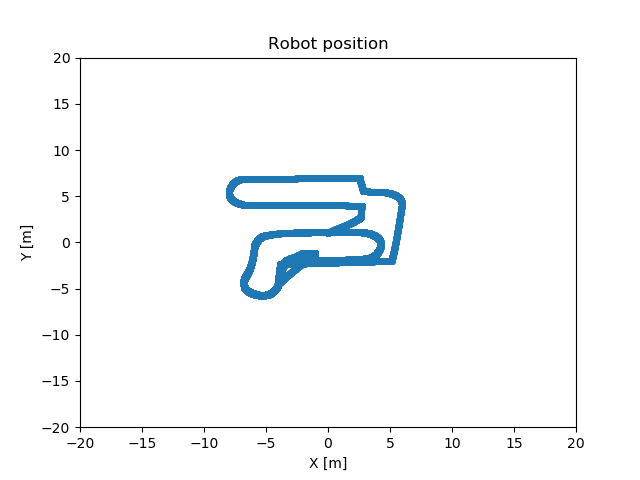

<IPython.core.display.Javascript object>


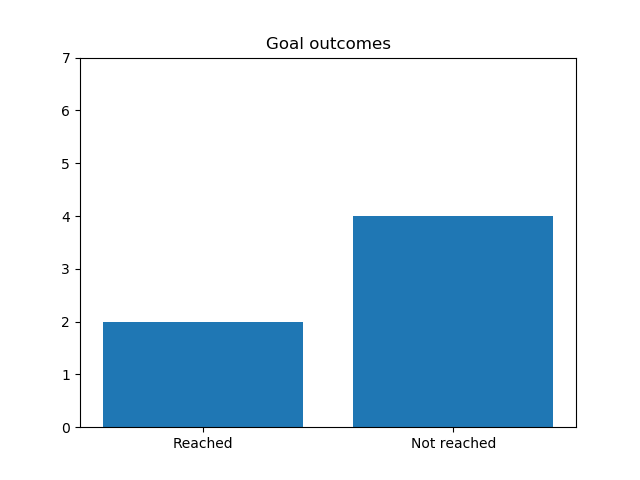

In [11]:
fig1, ax1 = plt.subplots()
line, = ax1.plot([], [], '-o', markersize=4)
ax1.set_title("Robot position")
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")
ax1.set_xlim(-20, 20)
ax1.set_ylim(-20, 20)

def update_position(frame):
    # aggiorna dati
    line.set_data(pos_x, pos_y)
    # ridimensiona assi se serve
    ax1.relim()
    ax1.autoscale_view()
    return (line,)

ani_pos = FuncAnimation(fig1, update_position, interval=500)


# 3.2) figura per il conteggio reached / not reached
fig2, ax2 = plt.subplots()
bars = ax2.bar(['Reached', 'Not reached'], [0, 0])
ax2.set_title("Goal outcomes")
ax2.set_ylim(0, max(5, successes + failures + 1))

def update_counts(frame):
    # aggiorna altezze
    bars[0].set_height(successes)
    bars[1].set_height(failures)
    # riallarga asse Y se necessario
    total = successes + failures
    ax2.set_ylim(0, max(5, total + 1))
    return bars

ani_counts = FuncAnimation(fig2, update_counts, interval=500)